## Advanced Lane Finding

Brian Erickson

### Abstract
This project aims to find the position of a car in the lane along with the curvature of the road by using advanced lane line finding tecniques.  This is an extension of the earlier lane finding project.  My work for that project is at https://github.com/berickson/CarND-LaneLines-P1 and you can view the notebook at http://nbviewer.jupyter.org/github/berickson/CarND-LaneLines-P1/blob/master/P1.ipynb.  This is all imlemented as part of the Udacity Self Driving Car Nanodegree.


#### Imports and Helper Functions

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython import display
import glob

%matplotlib inline

#### Goal: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [52]:
calibration_images = glob.glob('camera_cal/calibration*.jpg')

In [53]:
input_videos = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]

In [54]:
test_images = glob.glob('test_images/*.jpg')

In [55]:
class Camera:
    def __init__(self):
        self.calibrated = False
        
    def calibrate(self, show_annoted = False, show_corrected = False):
        w=9
        h=6
        pattern_size = (w,h)

        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        single_object_points = np.zeros((w*h,3), np.float32)
        single_object_points[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2)

        all_object_points = []
        all_image_points = []
        im_shape = None

        for image_path in calibration_images:
            im = plt.imread(image_path)
            im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
            if im_shape == None:
                im_shape = im_gray.shape[::-1]
            found,corners = cv2.findChessboardCorners(im,(9,6),None)
            if found==False: 
                continue
            corners2 = cv2.cornerSubPix(im_gray,corners,(11,11),(-1,-1),criteria)
            all_image_points.append(corners2)
            all_object_points.append(single_object_points)
            if show_annoted:
                plt.figure()
                im_annoted = cv2.drawChessboardCorners(im, pattern_size, corners2, found)
                plt.imshow(im_annoted)

        ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(all_object_points, all_image_points, im_shape,None,None)
        self.distCoeffs = distCoeffs
        self.cameraMatrix = cameraMatrix
        self.calibrated = True
        if show_corrected:
            for image_path in calibration_images:
                im = plt.imread(image_path)   
                plt.figure()
                plt.imshow(cv2.undistort(im,mtx,dst))
    
    def undistort(self, im):
        if not self.calibrated:
            self.calibrate()
        return cv2.undistort(im,self.cameraMatrix,self.distCoeffs)


In [56]:
camera = Camera()

In [57]:
camera.calibrate()

#### Goal: Apply a distortion correction to raw images

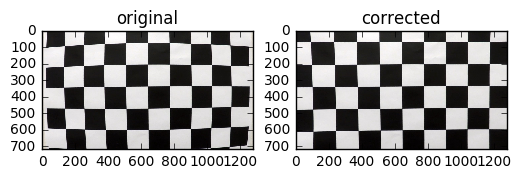

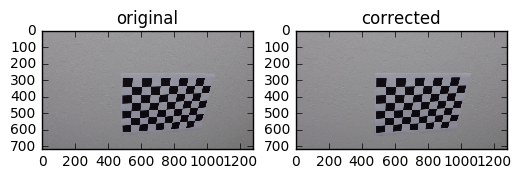

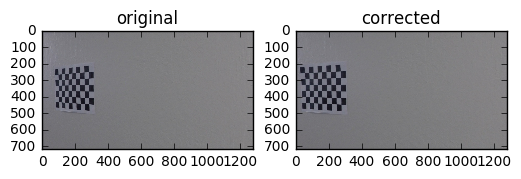

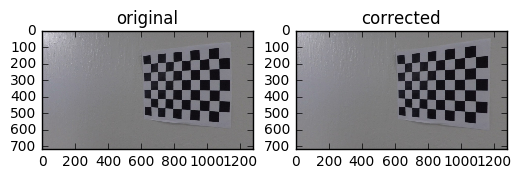

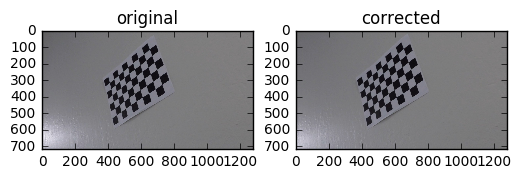

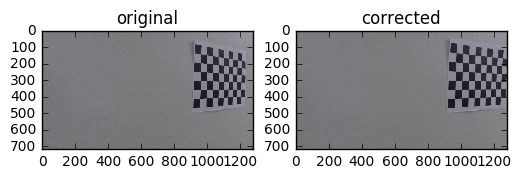

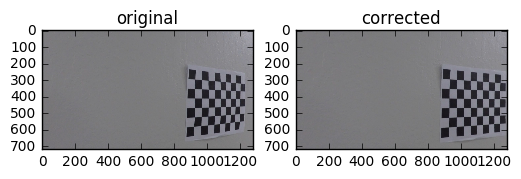

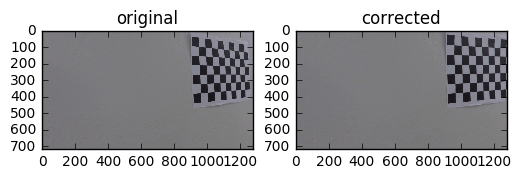

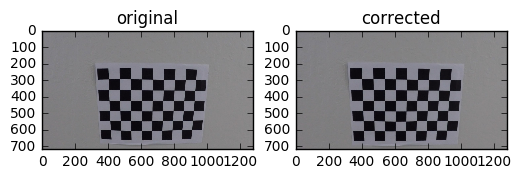

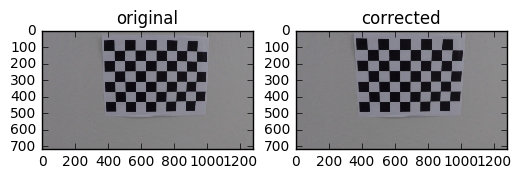

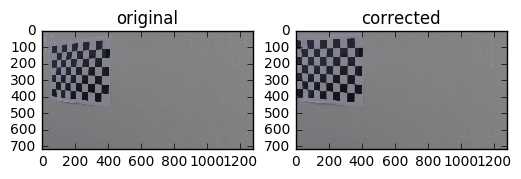

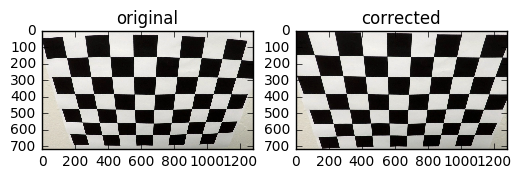

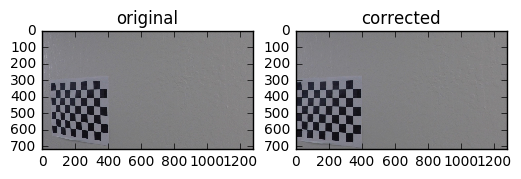

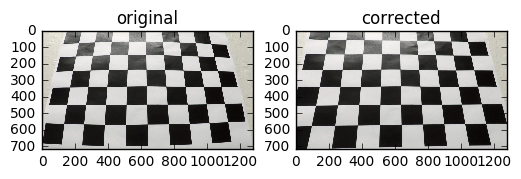

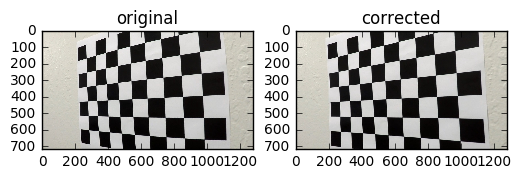

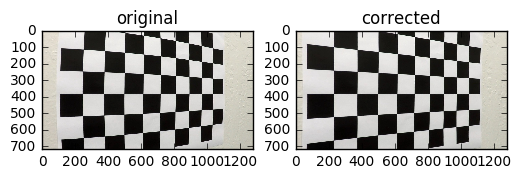

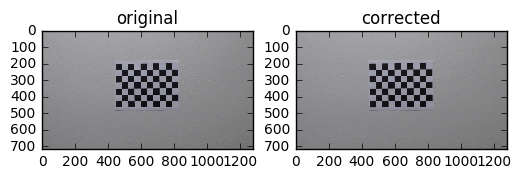

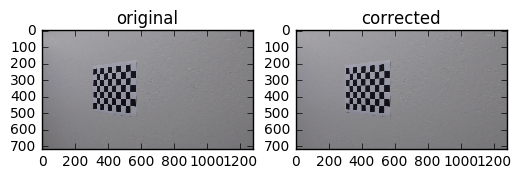

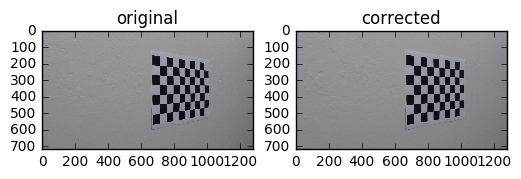

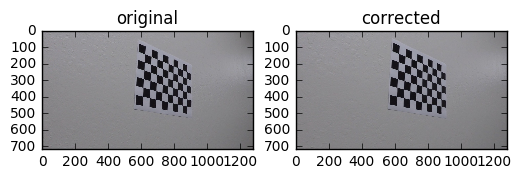

In [58]:
for image_path in calibration_images:
    im = plt.imread(image_path)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title("original")
    plt.subplot(1,2,2)
    im_fixed = camera.undistort(im)
    plt.imshow(im_fixed)
    plt.title("corrected")
    outpath = 'output_images/undistorted_'+os.path.basename(image_path)
    plt.imsave(outpath,im_fixed)

In [59]:
def get_filename(path):
    '''
    returns the filename part of path, without extension
    '''
    return os.path.basename(path).split(".")[0]
    
get_filename('/abc/myfile.ab')

'myfile'

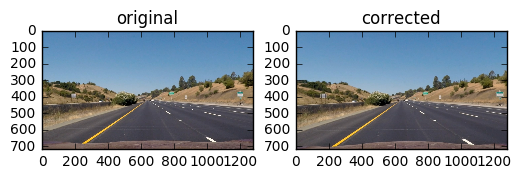

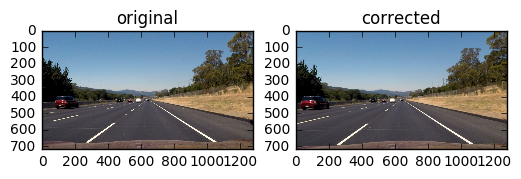

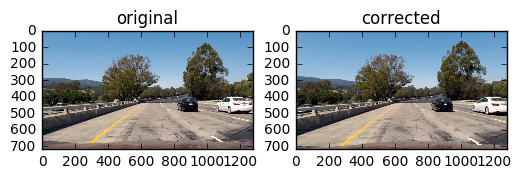

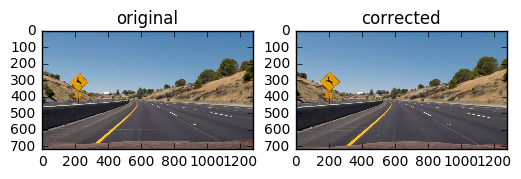

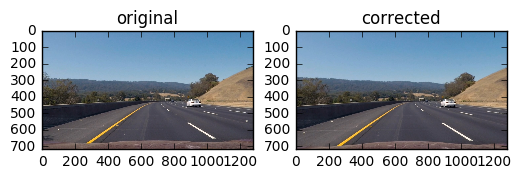

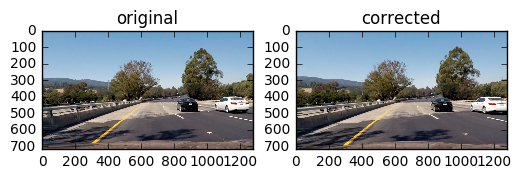

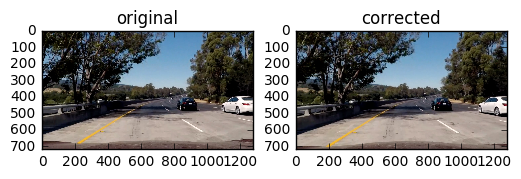

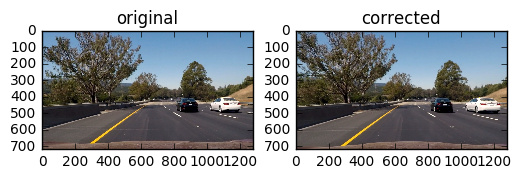

In [60]:
for image_path in test_images:
    im = plt.imread(image_path)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title("original")
    plt.subplot(1,2,2)
    im_undistorted = camera.undistort(im)
    plt.imshow(im_undistorted)
    out_path = 'output_images/undistorted_'+get_filename(image_path)+'.jpg'
    plt.imsave(out_path, im_undistorted)
    plt.title("corrected")

#### Goal: Use color transforms, gradients, etc., to create a thresholded binary image

In [61]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        if line is not None:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def print_image(img,title=None):
    plt.figure()
    if title is not None:
        plt.title(title)
    plt.imshow(img,cmap='gray')

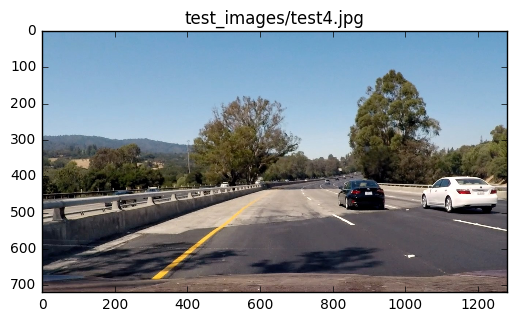

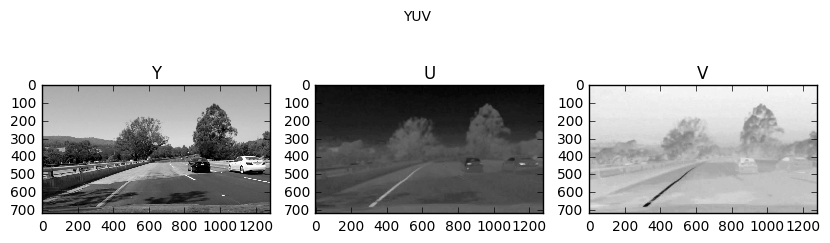

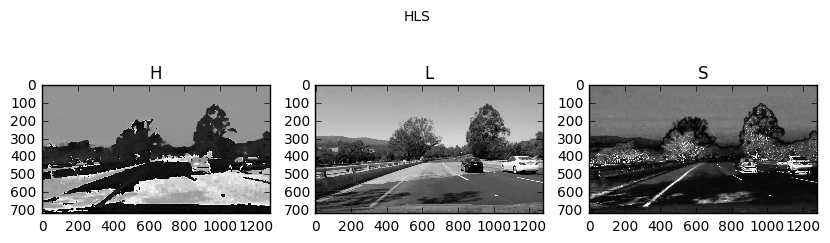

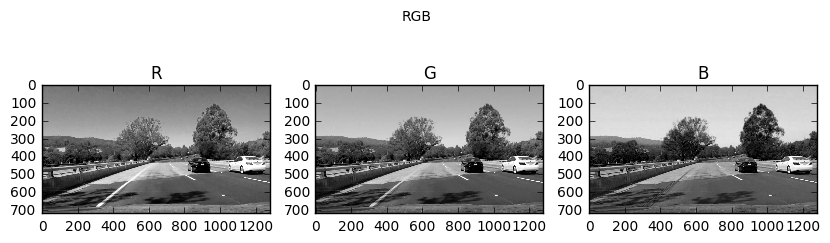

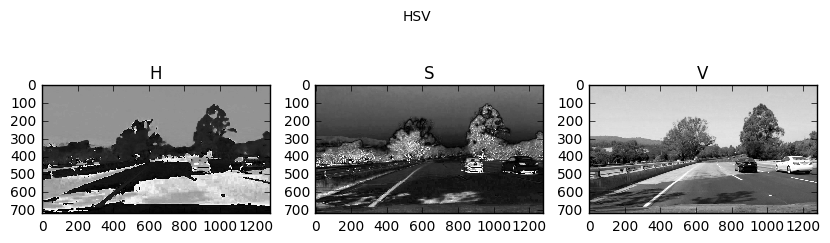

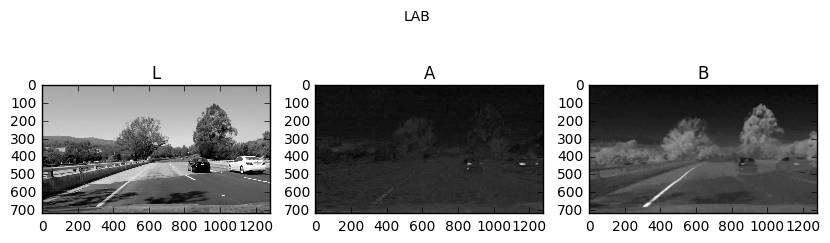

In [62]:
color_spaces = {"HLS": cv2.COLOR_RGB2HLS, "HSV": cv2.COLOR_RGB2HSV, "YUV":cv2.COLOR_RGB2YUV,"LAB":cv2.COLOR_RGB2LAB,"RGB":None}
for f in glob.glob('test_images/test4.jpg'):
    plt.figure()
    plt.title(f)
    im = plt.imread(f)
    plt.imshow(im)
    for space_name,space_conversion in color_spaces.items():
        fig = plt.figure()
        fig.suptitle(space_name)
        fig.set_size_inches(w=10,h=3)
        im2 = cv2.cvtColor(im,space_conversion) if space_conversion else im
        for i,c in enumerate(space_name):
            plt.subplot(1,3,i+1)
            plt.imshow(im2[:,:,i],cmap='gray')
            plt.title(c)

            

The "Y" term from YUV appears to have the most constistently bright lines, both for white and yellow, let's look at this for larger images, to make sure they all seem viable



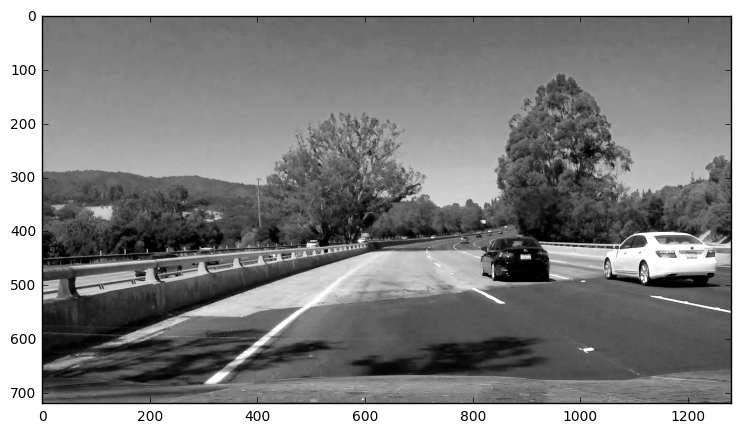

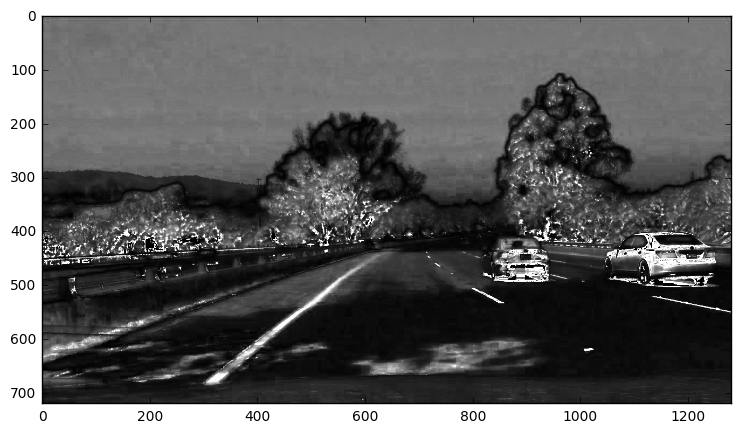

In [63]:
for f in glob.glob('test_images/test4.jpg'):
    plt.figure()
    #get Y
    im = plt.imread(f)
    fig = plt.figure()
    fig.set_size_inches(w=10,h=5)

    #plt.subplot(1,2,1)
    plt.imshow(im[:,:,0],cmap='gray')
    #plt.subplot(1,2,2)
    fig = plt.figure()
    fig.set_size_inches(w=10,h=5)
    plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2HLS)[:,:,2],cmap='gray');
    

Now make a video, to see how it works (turns out HL[S] wasn't good [R]GB was.

In [64]:
def lane_gray(im):
    return im[:,:,0]

In [65]:
def video_tag(path,width=300,height=240,title=""):
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [66]:
class SideBySideProcessor:
    def __init__ (self, process_callback):
        self.process_callback = process_callback
    def process_image(self, im):
        im_processed = self.process_callback(im)
        im_side_by_side = np.concatenate((im, im_processed), axis=1)
        return im_side_by_side

In [67]:
def process_videos(
    input_videos, 
    process_function, 
    prefix, output_folder = 'output_videos', 
    overwrite=False,
    plot=False,
    side_by_side=False
):
    output_paths = []
    if side_by_side:
        p = SideBySideProcessor(process_function)
        process_function = p.process_image

    
    for input_path in input_videos:
        output_path = output_folder+"/"+prefix+'_'+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path) or os.path.getmtime(output_path) < os.path.getmtime(input_path):
            clip1 = VideoFileClip(input_path)
            white_clip = clip1.fl_image(process_function) #NOTE: this function expects color images!!
            %time white_clip.write_videofile(output_path, audio=False)
        
        if plot:
            #html =  video_tag(input_path,title=input_path)
            html = video_tag(output_path,title=output_path)
            display.display(display.HTML(html))
    return output_paths
    

In [68]:
undistorted_videos = process_videos(input_videos, camera.undistort, prefix='undistorted',plot=True)

In [103]:
def process_images(input_images, process_function, prefix, output_folder = 'output_images', overwrite=True, plot=False):
    output_paths = []
    for input_path in input_images:
        output_path = output_folder+"/"+prefix+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path):
            im=plt.imread(input_path)
            im_processed = process_function(im)
            plt.imsave(output_path,im_processed)
        
        if plot:
            fig = plt.figure()
            fig.set_size_inches(w=10,h=5)
            plt.subplot(1,2,1)
            plt.title(input_path)
            plt.imshow(im)
            plt.subplot(1,2,2)
            plt.title(output_path)
            plt.imshow(im_processed,cmap='gray')
    return output_paths

In [70]:
def hsl_gray_rgb(im):
    return cv2.cvtColor(cv2.cvtColor(im,cv2.COLOR_RGB2HLS)[:,:,2],cv2.COLOR_GRAY2RGB)

In [71]:
process_videos(input_videos,hsl_gray_rgb,prefix='hsl_gray',plot=True,side_by_side=True)

['output_videos/hsl_gray_project_video.mp4',
 'output_videos/hsl_gray_challenge_video.mp4',
 'output_videos/hsl_gray_harder_challenge_video.mp4']

In [72]:
def lane_gray_rgb(im):
    return cv2.cvtColor(lane_gray(im),cv2.COLOR_GRAY2RGB)

In [73]:
process_videos(input_videos,lane_gray_rgb,prefix='lane_gray',side_by_side=True ,plot=True)

['output_videos/lane_gray_project_video.mp4',
 'output_videos/lane_gray_challenge_video.mp4',
 'output_videos/lane_gray_harder_challenge_video.mp4']

#### Goal: Apply a perspective transform to rectify binary image ("birds-eye view")

The Interstate Highway standards for the U.S. Interstate Highway System uses a 12-foot (3.7 m) standard for lane width
http://www.dot.ca.gov/trafficops/camutcd/docs/TMChapter6.pdf p.31

3.66m marking, 11m between, dot between

In [74]:
def birds_eye(im,flags=cv2.INTER_LINEAR):
    im_shape = (im.shape[1],im.shape[0]) # im_shape (1280, 720)
    # polygons to warp based on eyeballing lanes in Gimp
    src = np.array([(270,675),(615,434),(666,434),(1050,675)],dtype=np.float32)
    #for p in src:
    #    plt.plot(p[0],p[1],'.')
    dst = np.array([(270,710),(270,-600),(1050,-600),(1050,710)],dtype=np.float32)
    dst[:,0] = 0.08805 * dst[:,0] + 540 # constant makes lane width to marker spacing ratio correct
    transform = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(im,transform,im_shape)

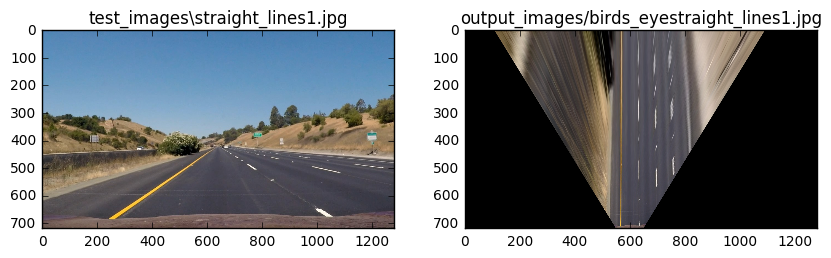

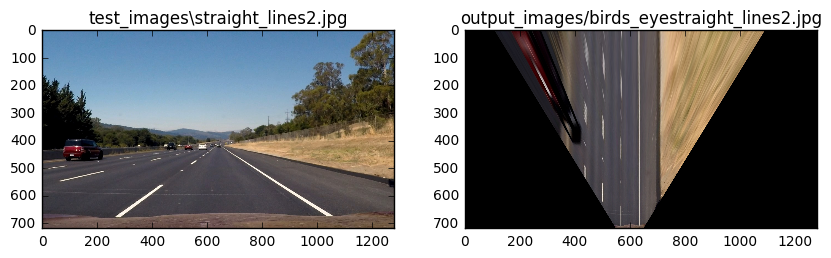

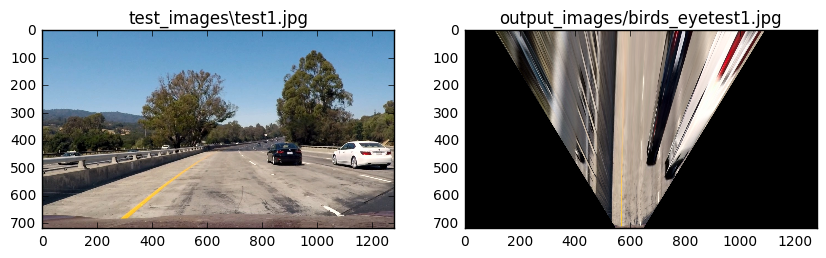

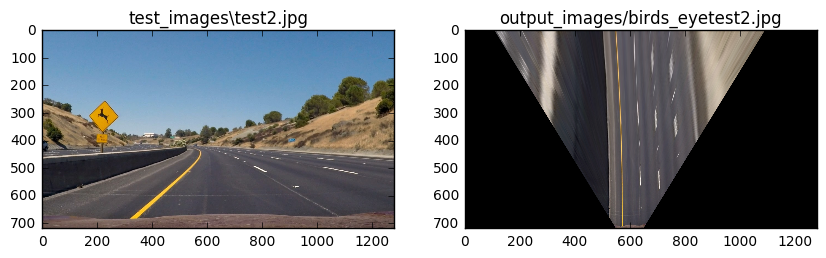

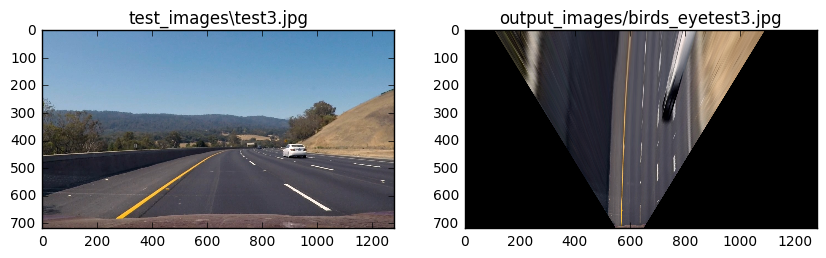

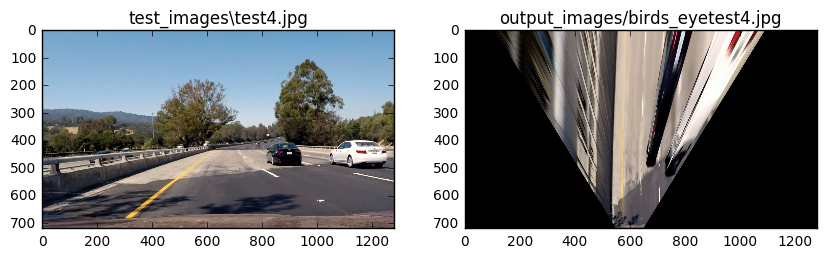

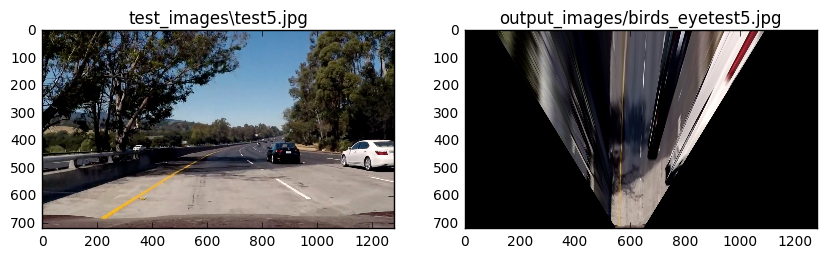

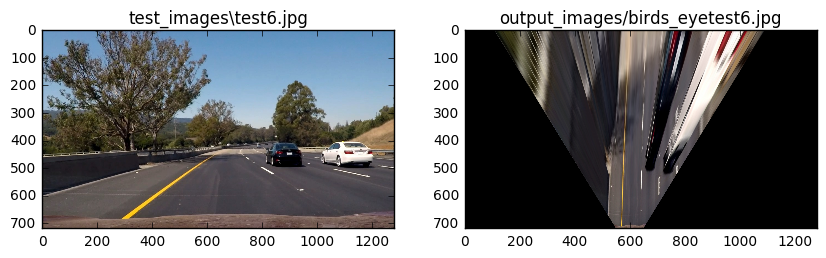

In [75]:
process_images(test_images, birds_eye, prefix="birds_eye",plot = True)

In [76]:
process_videos(undistorted_videos, birds_eye,'birds_eye',side_by_side=True,plot=True)  

['output_videos/birds_eye_undistorted_project_video.mp4',
 'output_videos/birds_eye_undistorted_challenge_video.mp4',
 'output_videos/birds_eye_undistorted_harder_challenge_video.mp4']

In [77]:
clip_region = np.int32([[(175,675),(1200,675),(800,450),(575,450)]])

In [78]:
def threshold(gray):
    t = np.percentile(gray,99.6)
    _,rv= cv2.threshold(gray, t-1, 255, cv2.THRESH_BINARY)
    return rv

In [79]:
def threshold_with_clip_region(im):
    roi=region_of_interest(im,clip_region)
    return threshold(lane_gray(roi))

def threshold_with_clip_region_rgb(im):
    im2=threshold_with_clip_region(im)
    return cv2.cvtColor(im2,cv2.COLOR_GRAY2RGB)

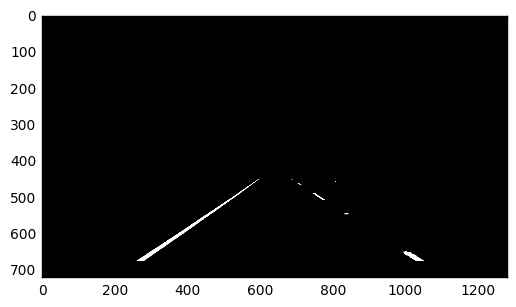

In [80]:
plt.imshow(threshold_with_clip_region_rgb(plt.imread(test_images[0])))

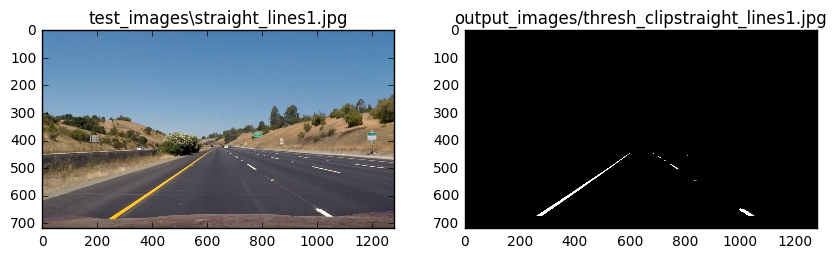

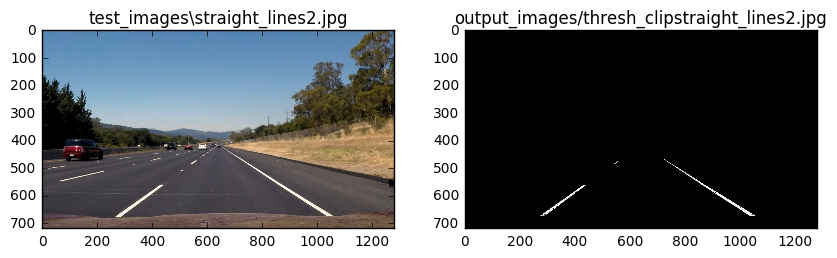

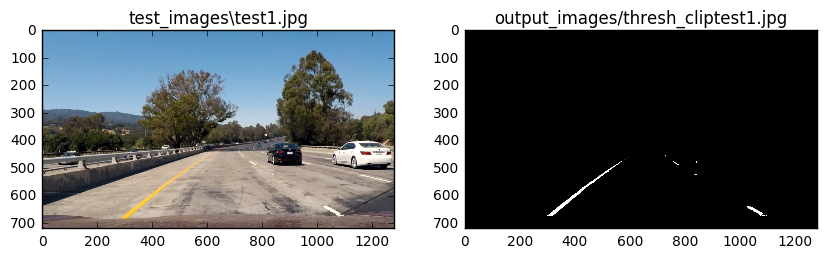

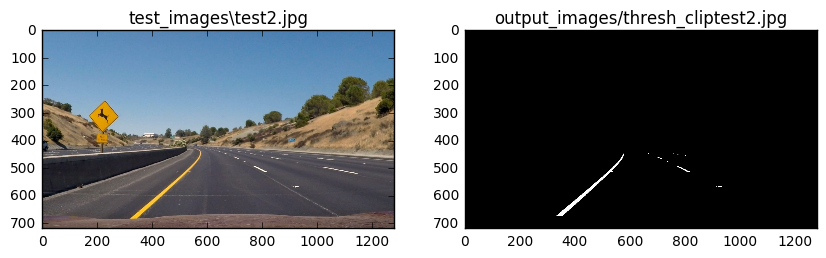

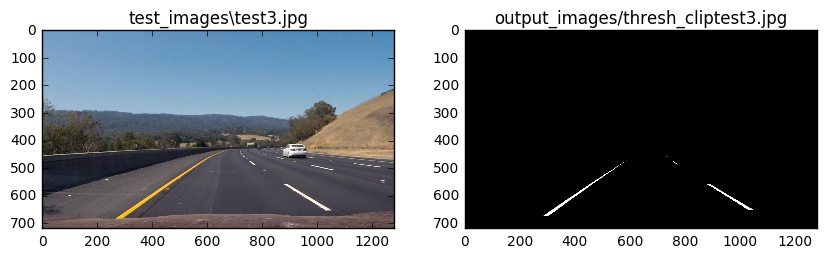

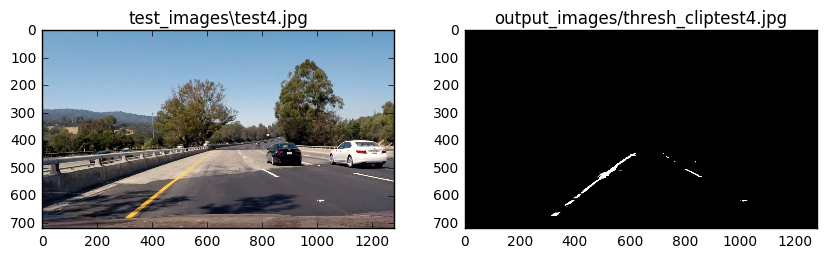

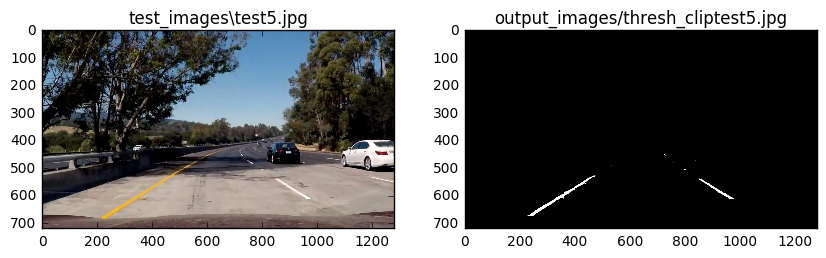

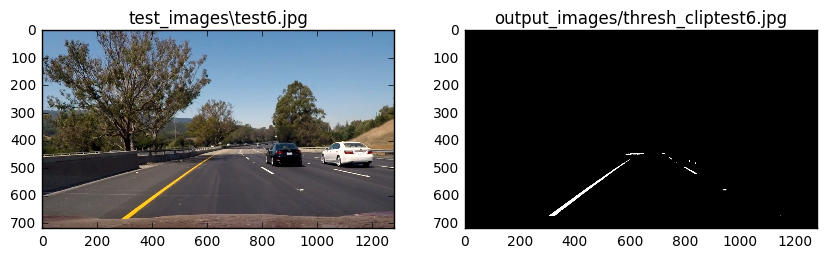

In [104]:
threshold_images = process_images(test_images, threshold_with_clip_region_rgb, prefix='thresh_clip', plot=True)

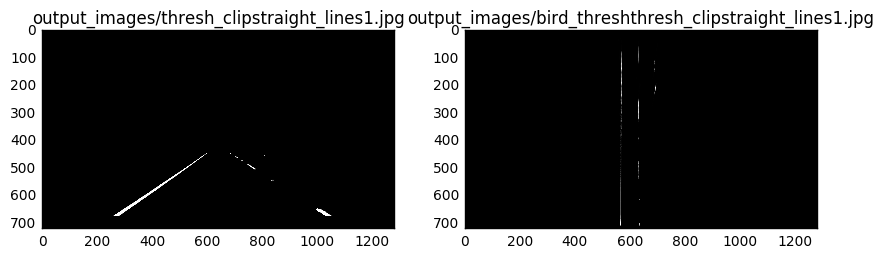

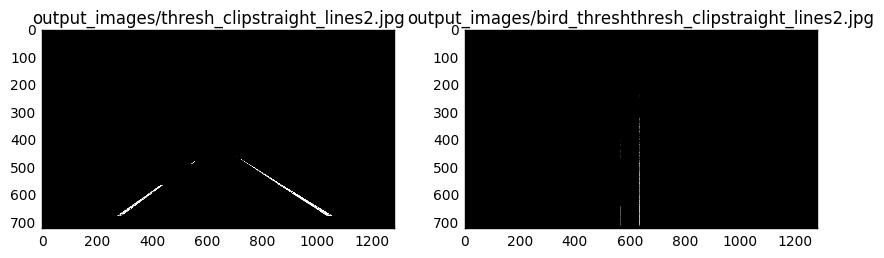

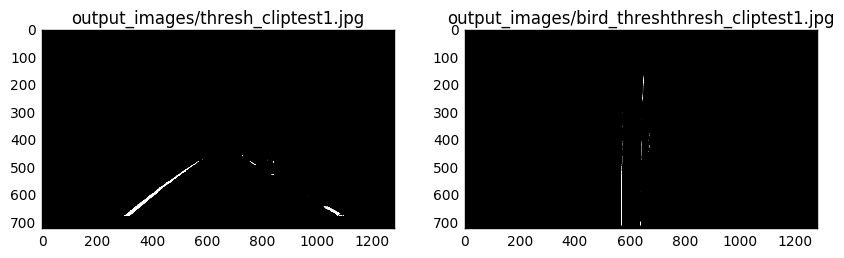

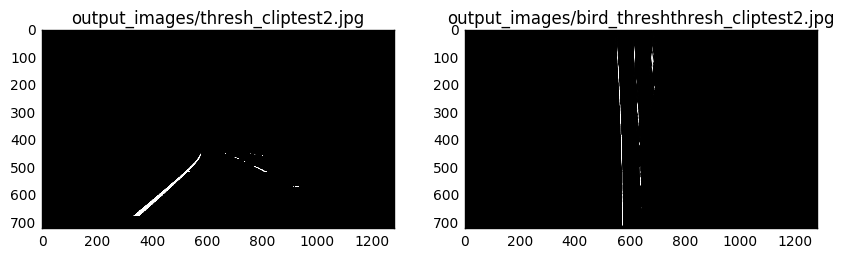

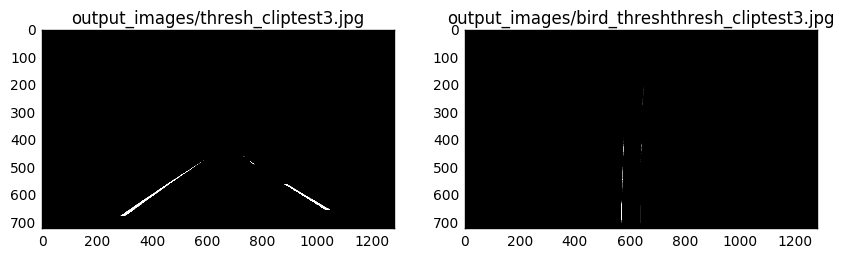

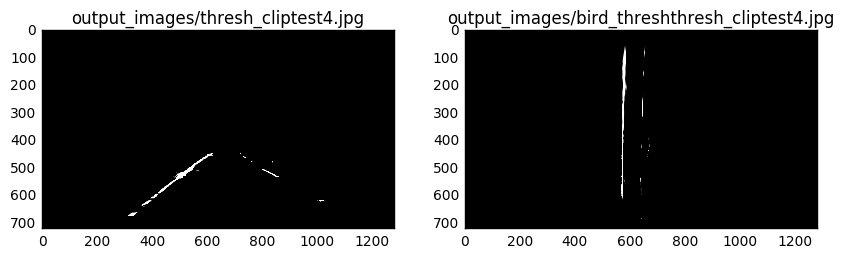

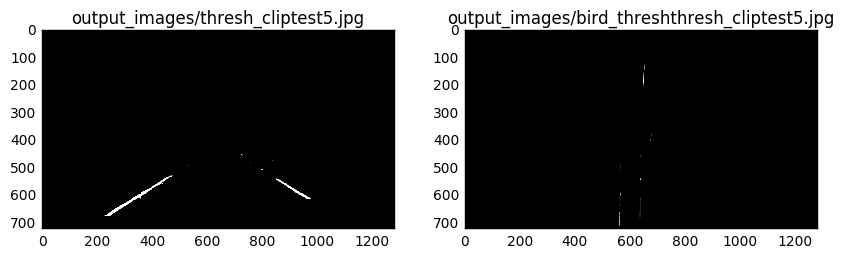

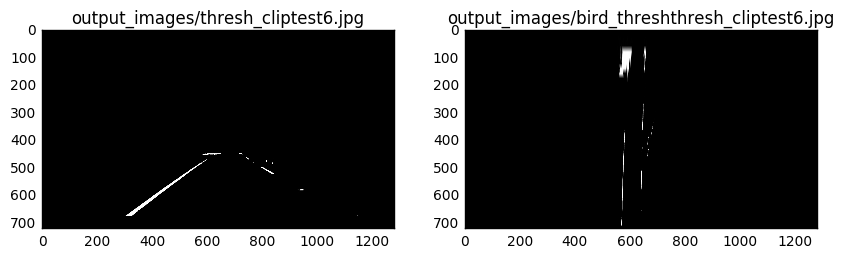

In [105]:
bird_thresh_images = process_images(threshold_images, birds_eye, prefix='bird_thresh', plot=True)

In [131]:
a=[1,4,39,2]
np.argmax(a)

2

In [163]:
from PIL import Image, ImageDraw

In [178]:
def find_lanes_on_birdseye(im, plot=False):
    h = np.sum(im[500:,:,0],axis=0)
    mid=600
    x1 = np.argmax(h[0:mid])
    x2 = np.argmax(h[mid:])+mid
    if plot:
        plt.axvline(x=x1,color='g')
        plt.axvline(x=x2,color='g')
        plt.plot(h)
    return x1,x2


In [184]:
def draw_lanes_on_birdseye(im,x1,x2):
    for x in [x1,x2]:
        cv2.line(im,(x,0),(x,750),(0,0,255,100),thickness=3)
    s = "x1: {} x2: {} distance: {}".format(x1,x2,x2-x1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im,s,(10,100), font, 2,(255,255,255),4,cv2.LINE_AA)
    return im

def find_and_draw_lanes_on_birdseye(im):
    x1,x2=find_lanes_on_birdseye(im)
    draw_lanes_on_birdseye(im,x1,x2)
    return im

8


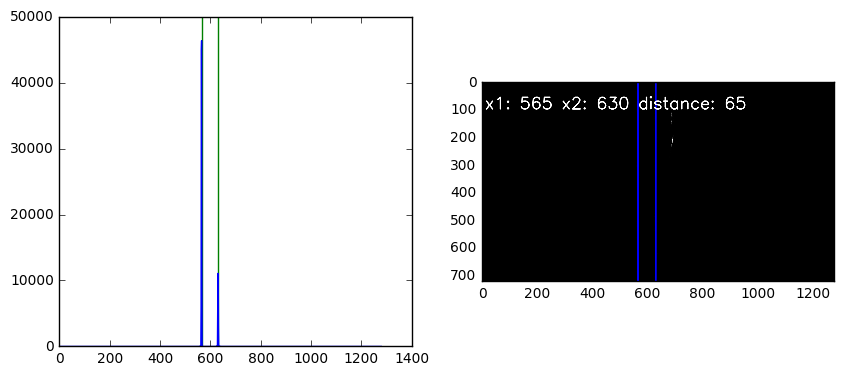

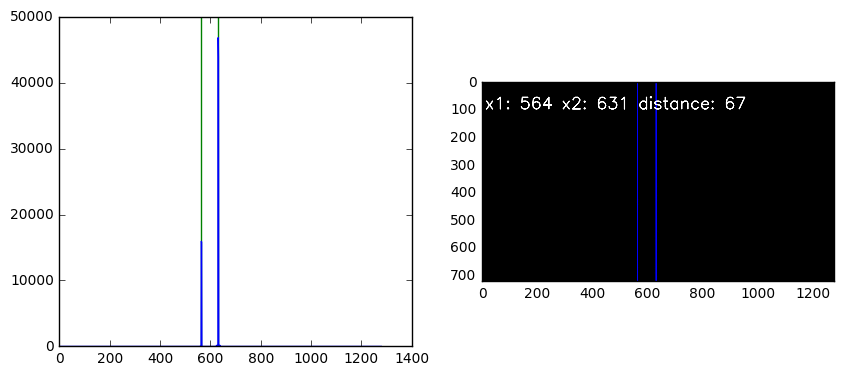

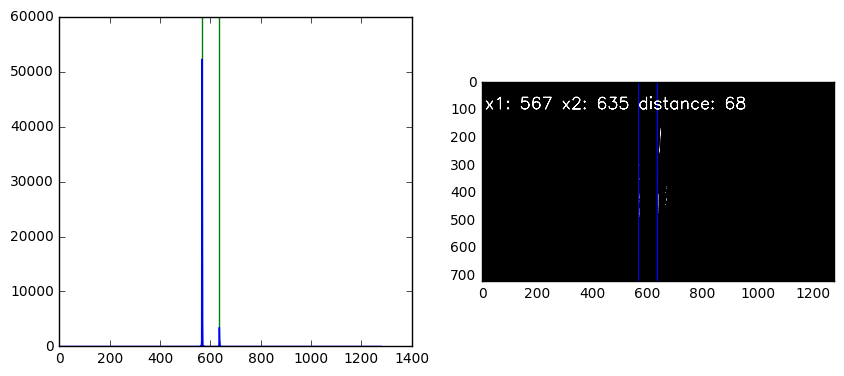

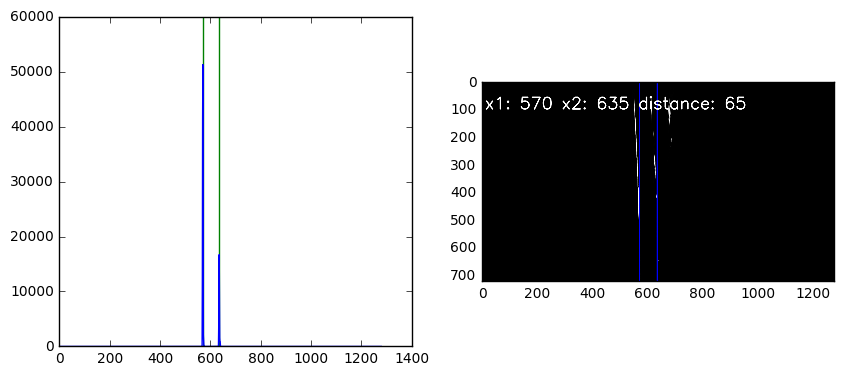

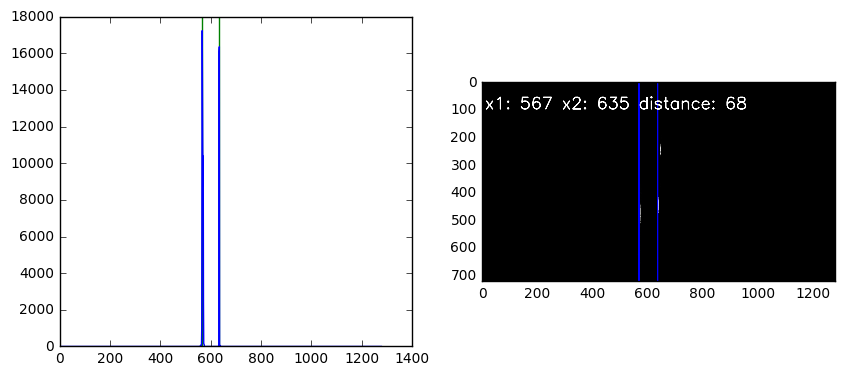

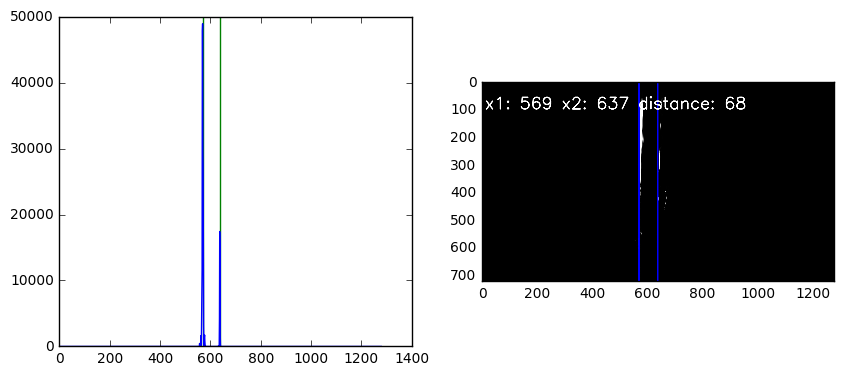

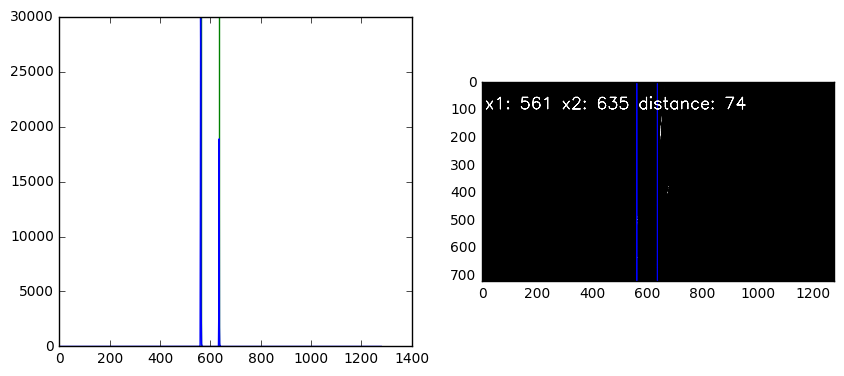

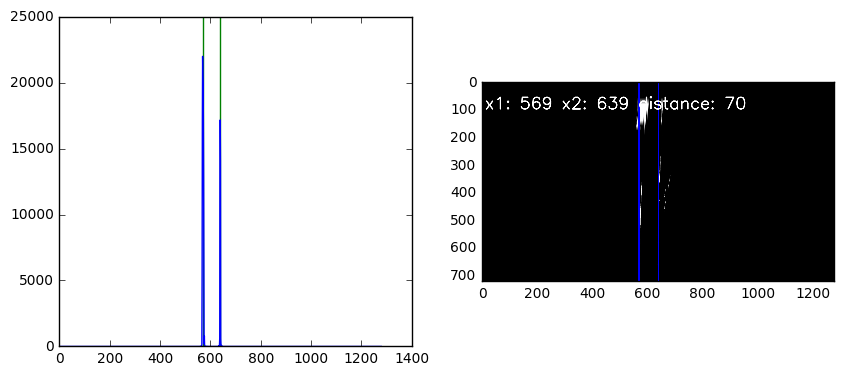

In [180]:

rows = len(bird_thresh_images)
print(rows)
i=0
for image_path in bird_thresh_images:
    im=plt.imread(image_path)
    fig=plt.figure()
    fig.set_size_inches(w=10,h=5*rows)
    i += 1
    plt.subplot(rows,2,i)
    x1,x2=find_lanes_on_birdseye(im,plot=True)
    i += 1
    plt.subplot(rows,2,i)
    draw_lanes_on_birdseye(im,x1,x2)
    plt.imshow(im)
    #plt.title("x1: {} x2: {} distance: {}".format(x1,x2,x2-x1))
    


In [82]:
process_videos(input_videos,threshold_with_clip_region_rgb, prefix='thresh_clip', plot=True,side_by_side=True)

['output_videos/thresh_clip_project_video.mp4',
 'output_videos/thresh_clip_challenge_video.mp4',
 'output_videos/thresh_clip_harder_challenge_video.mp4']

In [182]:
def birds_thresh(im):
    return birds_eye(threshold_with_clip_region_rgb(im))

birds_thresh_videos = process_videos(undistorted_videos, birds_thresh,'birds_thresh') 

[MoviePy] >>>> Building video output_videos/birds_thresh_undistorted_project_video.mp4
[MoviePy] Writing video output_videos/birds_thresh_undistorted_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:17<00:00, 16.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/birds_thresh_undistorted_project_video.mp4 

Wall time: 1min 17s
[MoviePy] >>>> Building video output_videos/birds_thresh_undistorted_challenge_video.mp4
[MoviePy] Writing video output_videos/birds_thresh_undistorted_challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:31<00:00, 17.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/birds_thresh_undistorted_challenge_video.mp4 

Wall time: 31.5 s
[MoviePy] >>>> Building video output_videos/birds_thresh_undistorted_harder_challenge_video.mp4
[MoviePy] Writing video output_videos/birds_thresh_undistorted_harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [01:18<00:00, 15.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/birds_thresh_undistorted_harder_challenge_video.mp4 

Wall time: 1min 19s


In [185]:
hist_lanes_videos = process_videos(birds_thresh_videos, find_and_draw_lanes_on_birdseye, prefix='hist_lanes',plot=True)

[MoviePy] >>>> Building video output_videos/hist_lanes_birds_thresh_undistorted_project_video.mp4
[MoviePy] Writing video output_videos/hist_lanes_birds_thresh_undistorted_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [00:40<00:00, 31.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/hist_lanes_birds_thresh_undistorted_project_video.mp4 

Wall time: 40.9 s


[MoviePy] >>>> Building video output_videos/hist_lanes_birds_thresh_undistorted_challenge_video.mp4
[MoviePy] Writing video output_videos/hist_lanes_birds_thresh_undistorted_challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:17<00:00, 27.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/hist_lanes_birds_thresh_undistorted_challenge_video.mp4 

Wall time: 18.4 s


[MoviePy] >>>> Building video output_videos/hist_lanes_birds_thresh_undistorted_harder_challenge_video.mp4
[MoviePy] Writing video output_videos/hist_lanes_birds_thresh_undistorted_harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [00:44<00:00, 27.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/hist_lanes_birds_thresh_undistorted_harder_challenge_video.mp4 

Wall time: 44.6 s


In [84]:
def grey_birds_eye_rgb(im):
    return birds_eye(lane_gray_rgb(im))

process_videos(undistorted_videos, grey_birds_eye_rgb,'grey_birds_eye',side_by_side=True,plot=True)   

[MoviePy] >>>> Building video output_videos/grey_birds_eye_undistorted_project_video.mp4
[MoviePy] Writing video output_videos/grey_birds_eye_undistorted_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:20<00:00,  6.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/grey_birds_eye_undistorted_project_video.mp4 

Wall time: 3min 24s


['output_videos/grey_birds_eye_undistorted_project_video.mp4',
 'output_videos/grey_birds_eye_undistorted_challenge_video.mp4',
 'output_videos/grey_birds_eye_undistorted_harder_challenge_video.mp4']

#### Goal: Detect lane pixels and fit to find the lane boundary

In [85]:
def oriented_gradient(img,ksize=5, debug=False, deg=0):
    sobelx = cv2.Sobel(img,cv2.CV_32F,dx=1,dy=0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_32F,dx=0,dy=1,ksize=ksize)
    oriented = sobelx + (1.0j * sobely)
    direction = np.angle(oriented,deg=deg)
    magnitude = np.abs(oriented)


    if debug:
        plt.figure()
        plt.title('sobelx')
        plt.imshow(sobelx, cmap='gray')
        plt.figure()
        plt.title('sobely')
        plt.imshow(sobely, cmap='gray')
    
    if debug:
        plt.figure()
        plt.title('direction')
        plt.imshow(direction,cmap='gray')
    
    if debug:
        plt.figure()
        plt.title('magnitude')
        plt.imshow(magnitude,cmap='gray')
    return magnitude,direction


def gradient_for_angles(magnitude,direction,theta,tolerance):
    filter = np.logical_and(direction > theta-tolerance,direction < theta+tolerance)
    gradient = np.multiply(filter,magnitude)
    return gradient
        
def im_float_to_int(img):
    low = np.min(img)
    high = np.max(img)
    out = np.uint8((np.subtract(img,low)/(high-low))*255.)
    return out

def im_int_to_binary(img, threshold = None):
    if threshold is None:
        threshold=np.mean(img)
    th, dst = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    
    return dst

def show_gradient_for_angles(magnitude,direction,theta,tolerance):
    matched = gradient_for_angles(magnitude,direction,theta,tolerance)

    plt.figure()
    plt.title('matched: {} tolerance {}, max={}'.format(theta,tolerance,np.max(matched)))
    imint = im_float_to_int(matched)
    plt.imshow(imint,cmap='gray')


In [86]:
class LaneLine:
    def __init__(self, expected_gradient=0, color=(255,255,255), name=None):
        self.name = name
        self.color = color
        self.expected_gradient = expected_gradient
        self.line = None

In [87]:
# globals
red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
cyan = (0,255,255)
white = (255,255,255)

In [88]:
# see http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html

from sklearn import linear_model, datasets
def ransac_fit(x,y):
    #print("x: {}".format(x))
    #print("y: {}".format(y))
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=5)
    model_ransac.fit(x, y)
    return model_ransac

def ransac_image(img,predict_x=True):
    x,y = np.nonzero(img)
    x = x.reshape(len(x),1)
    y = y.reshape(len(y),1)
    #print(x)
    #print(y)
    try:
        if predict_x:
            model=ransac_fit(y,x)
        else:
            model=ransac_fit(x,y)
    except:
        model = None
    #print("ransac coef:{} intercept:{}".format(model.estimator_.coef_, model.estimator_.intercept_))
    return model
    


In [89]:
class lane_image_processor:
    def __init__(self):
        self.show_hough = False
        self.use_hough = False
        self.use_ransac = True
        self.clip_region =  [(175,700),(1200,700),(800,450),(575,450)]
        self.draw_clip_region = False
        self.lane_lines = []
        self.lane_lines.append(LaneLine(60.,red,'outer_left'))
        #self.lane_lines.append(LaneLine(-125.,green,'inner_left'))
        #self.lane_lines.append(LaneLine(-60.,blue,'inner_right'))
        self.lane_lines.append(LaneLine(120.,cyan,'outer_right'))
        
        # calc top and bottom of region of interest
        self.min_y = 99999
        self.max_y = 0
        for x,y in self.clip_region:
            if y < self.min_y:
                self.min_y = y
            if y > self.max_y:
                self.max_y = y
        
    
    def process_image(self, img):
        #img = mpimg.imread("test_images/solidYellowCurve.jpg")
        gray = lane_gray(img)
        mag,direction = oriented_gradient(gray,deg=1)
        #print_image(mag,'mag')
        #print_image(direction,'direction')
        for lane_line in self.lane_lines: # lane detectors ordered from left to right
            #print(lane_line.expected_gradient)
            imfloat = gradient_for_angles(mag,direction, lane_line.expected_gradient,10)
            #print_image(imfloat, "imfloat")
            imint = im_float_to_int(imfloat)
            #print_image(imint, "imint")
            imbinary = im_int_to_binary(imint,20)
            if self.clip_region is not None:
                imbinary = region_of_interest(imbinary,np.int32([self.clip_region]))
            if lane_line.line is not None:
                x1,y1,x2,y2=lane_line.line
                #print("x1={} y1={} x2={} y2={}".format(x1,y1,x2,y2))
                gap = 25
                clip_line = [(x1-gap,y1),(x1+gap,y1),(x2+gap,y2),(x2-gap,y2)]
                imbinary = region_of_interest(imbinary,np.int32([clip_line]))
            if self.draw_clip_region:
                cv2.polylines(img, np.int32([self.clip_region]), isClosed=True, color=white, thickness=3)
            
            #print_image(imbinary,"imbinary")
            #show_gradient_for_angles(mag,direction, theta,15)
            if self.use_hough:
                lines = cv2.HoughLinesP(imbinary, rho = 3, theta = 2 * math.pi/180., threshold=20, minLineLength=20, maxLineGap=3)
                if lines is not None:
                    if self.show_hough:
                        draw_lines(img,lines,color)
                    line = lane_line_from_lines(lines, self.clip_region)
                    #print(lane_line.line)
                    if line is not None:
                        lane_line.line = line
                        draw_lines(img,[[lane_line.line]],lane_line.color,thickness=4)

            #do ransac prediction
            if self.use_ransac:
                model = ransac_image(imbinary, predict_x=False)
                if model is not None:
                    min_x = model.predict(self.min_y)
                    max_x = model.predict(self.max_y)
                    lane_line.line = (min_x, self.min_y, max_x, self.max_y);
                    draw_lines(img,[[lane_line.line]], lane_line.color, thickness=4)
            #print_image(imbinary,'imbinary')
        return img

In [90]:
processor = lane_image_processor()

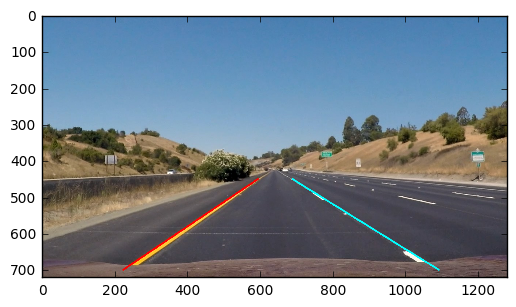

In [91]:
im = plt.imread('test_images/straight_lines1.jpg')
plt.imshow(processor.process_image(im))

In [92]:
process_videos(undistorted_videos,processor.process_image,plot=True,prefix="lane_lines")

[MoviePy] >>>> Building video output_videos/lane_lines_undistorted_project_video.mp4
[MoviePy] Writing video output_videos/lane_lines_undistorted_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:39<00:00,  3.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lane_lines_undistorted_project_video.mp4 

Wall time: 6min 42s


['output_videos/lane_lines_undistorted_project_video.mp4',
 'output_videos/lane_lines_undistorted_challenge_video.mp4',
 'output_videos/lane_lines_undistorted_harder_challenge_video.mp4']

#### Goal: Determine the curvature of the lane and vehicle position with respect to center.

#### Goal: Warp the detected lane boundaries back onto the original image.

#### Goal: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position